<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/Model_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load in relevant libraries, and alias where appropriate
import numpy as np # linear algebra
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install optim
import torch.optim as optim
!pip install torch torchvision torchaudio
from torchvision.io import read_image
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for optim: filename=optim-0.1.0-py2.py3-none-any.whl size=2718 sha256=0b42cd2821a6f8a11517a347fbedd568f8bfeff9cbeacf1c363979bb55b29294
  Stored in directory: /root/.cache/pip/wheels/ff/4a/36/b79913118fc97698a8b4eef8afd534a8b1fc4f1f36903bf67d
Successfully built optim
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe

In [3]:
# Define relevant variables for the ML task
start_epoch=0
num_epochs=60
lr=0.0001
patience=2
BATCH_SIZE=20
num_works=0
num_gpus=1
gpus=0

In [4]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [7]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

In [8]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'train.csv')
train_dataset = pd.read_csv(train_path)
validation_path = os.path.join(path,'validation.csv')
validation_dataset = pd.read_csv(validation_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_dataset = pd.read_csv(test_path)

In [9]:
train_dataset

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
10084,13259,94,False
10085,13261,94,False
10086,13274,94,False
10087,13286,94,False


In [10]:
validation_dataset

,id,boneage,male
0,10186,10,True
1,10758,15,False
2,10860,180,False
3,10877,180,False
4,11008,180,False
...,...,...,...
2517,15605,50,False
2518,15606,113,False
2519,15608,55,False
2520,15609,150,True


In [11]:
test_dataset

,Case ID,Sex,Ground truth bone age (months)
0,4360,M,169
1,4361,M,170
2,4362,M,73
3,4363,M,153
4,4364,M,135
...,...,...,...
195,4555,F,133
196,4556,F,129
197,4557,F,168
198,4558,F,136


In [12]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_dataset['id'] = train_dataset['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
validation_dataset['id'] = validation_dataset['id'].apply(lambda x: str(x)+'.png') 
test_dataset['Case ID'] = test_dataset['Case ID'].apply(lambda x: str(x)+'.png') 

train_dataset.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


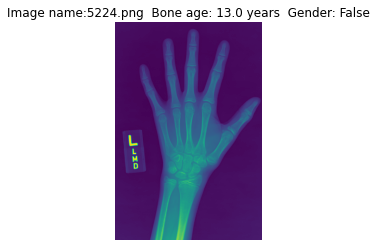

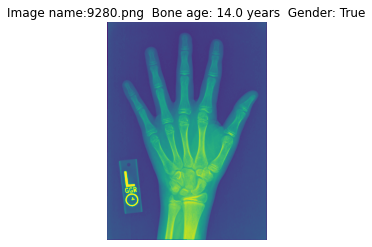

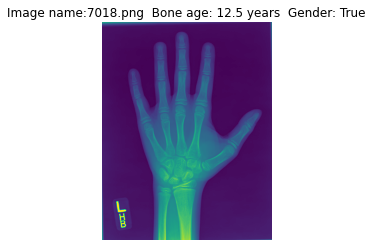

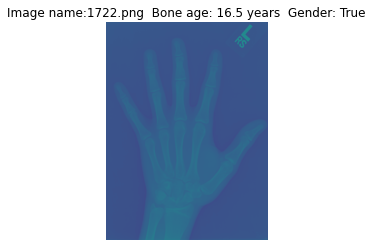

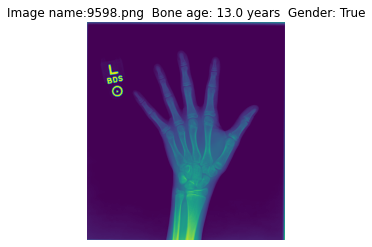

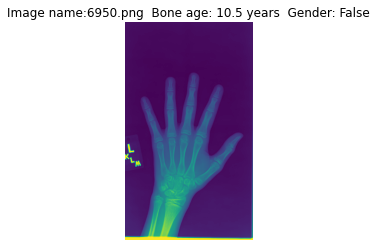

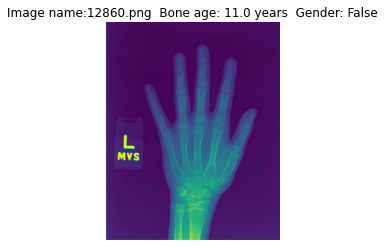

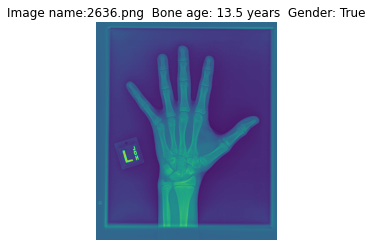

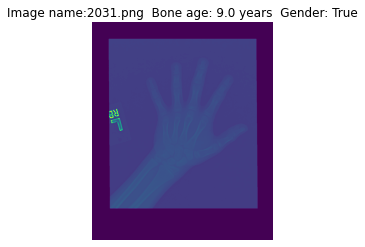

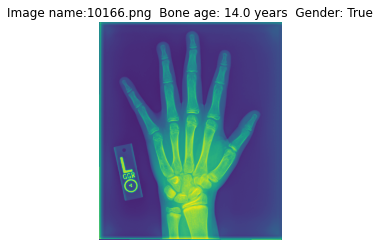

In [13]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python
for filename, boneage, gender in train_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    train_img = mpimg.imread(os.path.join(path,'boneage_training_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(train_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

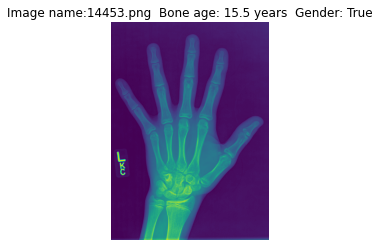

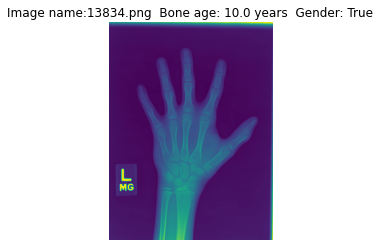

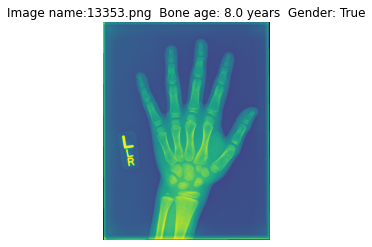

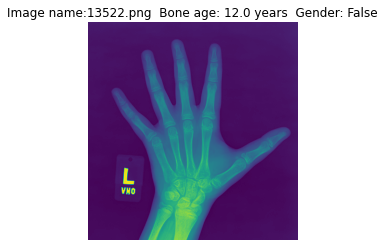

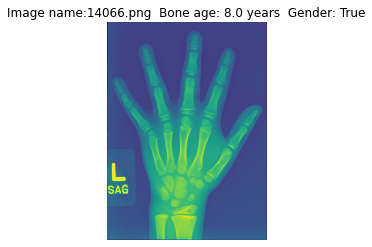

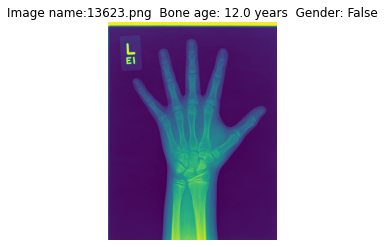

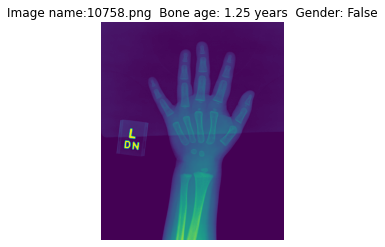

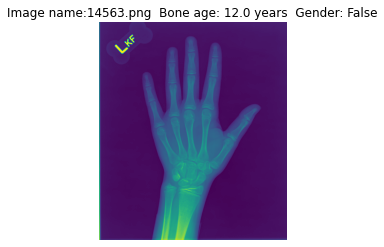

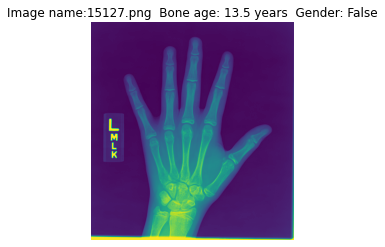

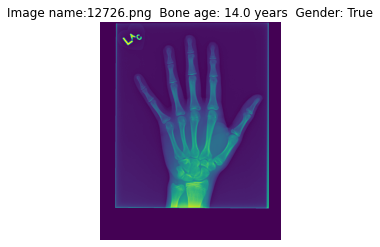

In [14]:
for filename, boneage, gender in validation_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    validation_img = mpimg.imread(os.path.join(path,'boneage_validation_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(validation_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

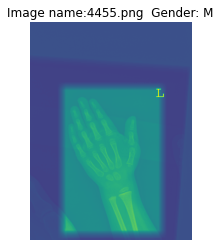

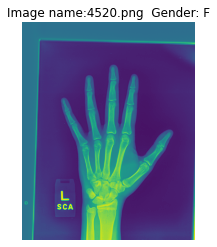

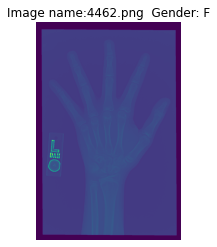

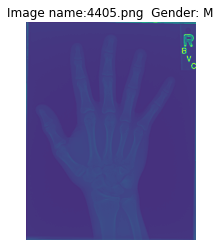

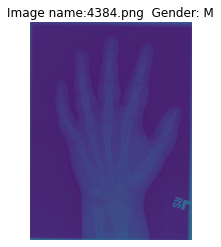

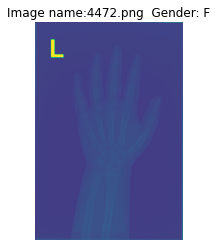

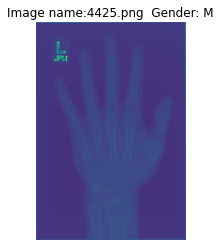

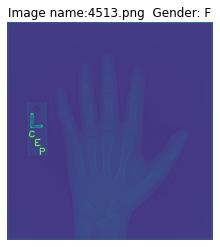

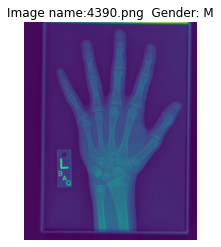

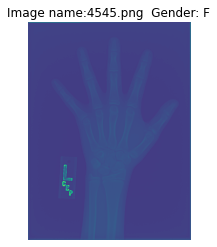

In [15]:
for filename, gender in test_dataset[['Case ID','Sex']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    test_img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(test_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

# Model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [17]:
model = Net() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [18]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Training

In [20]:
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataset):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, num_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_dataset):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_dataset))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



TypeError: ignored